# Описание проекта

Я являюсь аналитиком популярного сервиса аренды самокатов GoFast. Мне передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и ответитить на ряд вопросов, которые могут помочь вырасти бизнесу:
 - Тратят ли пользователи с подпиской больше времени на поездки?
 - Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
 - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
 - Как обновление серверов отразится на количество обращений пользователей?
____
Для анализа будет представлено три файла с данными:
  - Пользователи — `users_go.csv`:
    * __user_id__ - уникальный идентификатор пользователя
    * __name__	 - имя пользователя
    * __age__	 - возраст
    * __city__	 - город
    * __subscription_type__ - тип подписки (free, ultra)
____
  - Поездки — `rides_go.csv`:
	* __user_id__	- уникальный идентификатор пользователя
    * __distance__	- расстояние, которое пользователь проехал в текущей сессии (в метрах)
    * __duration__ - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    * __date__	- дата совершения поездки
___
  - Подписки — `subscriptions_go.csv`:
    * __subscription_type__ -	тип подписки
    * __minute_price__	- стоимость одной минуты поездки по данной подписке
    * __start_ride_price__ -	стоимость начала поездки
    * __subscription_fee__	- стоимость ежемесячного платежа
___
Приступим к нашему исследованию. Для начала импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import binom, poisson

#### Шаг 1. Загрузка данных

Загрузим все три датафрейма и проверим их содержимое

In [2]:
users = pd.read_csv('/datasets/users_go.csv') # пользователи
print(users.sample(5))
print()
users.info()

      user_id     name  age          city subscription_type
572       573     Петр   23     Краснодар             ultra
1521     1522   Никита   25  Екатеринбург              free
1151     1152  Альбина   21     Пятигорск              free
622       623    Нелли   19  Екатеринбург             ultra
446       447     Майя   19        Москва             ultra

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме с информацией о пользователях присутсвует 1565 строк, в который отсутствуют пропущенные значения. 

In [3]:
rides = pd.read_csv('/datasets/rides_go.csv') # поездки
print(rides.sample(5))
print()
rides.info()

       user_id     distance   duration        date
3714       399  4240.395709  22.600989  2021-09-01
5715       610  2995.765382  14.559330  2021-11-20
7569       776  4175.218256  22.946896  2021-12-09
4046       436  3004.453808  15.014846  2021-02-20
13714     1225  4698.701271  22.397403  2021-05-22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме с информацией о поездках присутствует 18068 строк и, также, отсуствуют пропуски.

In [4]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
print(subscriptions)
print()
subscriptions.info()

  subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме с информацией о подписках всего две строки, каждая из которых содержит информацию о бесплатной и ультра подписке соответственно.

#### Шаг 2. Предобработка данных

Нашу предобработку мы начнем с изменения типов данных в столбцах наших датафреймов. В датафрейме с информацией о поездках столбец с датой совершения поездки содержит тип данных `object`. Приведем тип данных к `datetime`

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Для дальнейшего исследования добавим в датафрейм отдельный столбец, который будет содержать в себе месяц поездки

In [6]:
rides['month'] = rides['date'].dt.month
rides.head()


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Округлим значения в столбце с продолжительностью поездок для того, чтобы в дальнейшем было удобнее считать выручку

In [7]:
rides['duration'] = np.ceil(rides['duration'])

Как мы и выяснили на этапе знакомства с данными, пропуски в них отсуствуют, давайте проанализируем датасеты на наличие дубликатов.

In [8]:
print('Количество повторяющихся строк:', users.duplicated().sum())
print()
users.duplicated()

Количество повторяющихся строк: 31



0       False
1       False
2       False
3       False
4       False
        ...  
1560     True
1561     True
1562     True
1563     True
1564     True
Length: 1565, dtype: bool

Очевидно, при сборе данных с конца датафрейма случайно добавили 31 строку, которые соответствуют уже существующим в датафрейме строкам. Их можно удалить.

In [9]:
users = users.drop_duplicates().reset_index(drop=True)
print(f'Процент удаленных данных составляет {round((31/1565)*100, 2)} %')

Процент удаленных данных составляет 1.98 %


Допустимые 1.98%. Теперь проверим датафрейм с поездками на наличие дубликатов.

In [10]:
rides.duplicated().sum()

0

Явные дубликаты отсуствуют, а неявные искать смысла нет, т.к. мы имеем дело с числами. Но неявные дубликаты в датафрейме с пользователями все же проверить стоит.

In [11]:
users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

Столько красивых имен и ни одно не повторяется! Теперь проверим столбец с населенными пунктами. 

In [12]:
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

**Вывод:**
 - Изменили тип данных в столбце `date` датафрейма с информацией о поездках с `object` на  `datetime`;
 - Добавили в датафрейм отдельный столбец с месяцем поездок для дальнейшего исследования;
 - Округлили значения в столбце с продолжительностью поездок;
 - Удалили 31 строку дубликат (1.98% данных). Дубликаты находились на последних строках датафрейма. Очевидно их добавили случайно или же произошла какая-то техническая ошибка.

#### Шаг 3. Исследовательский анализ данных

На данном этапе мы проведем исследование данных в столбцах для выявления некоторых закономерностей. Для начала напишем функцию, которая будет нам помогать с построением графиков.

In [13]:
def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

##### Частота встречаемости городов

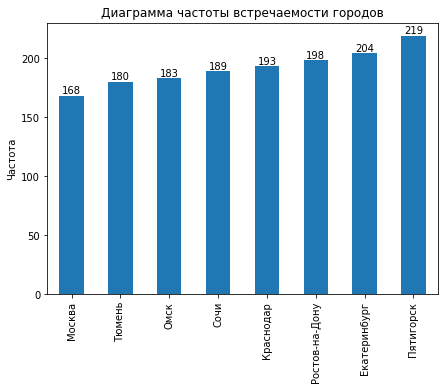

In [14]:
users['city'].value_counts(ascending=True).plot.bar(figsize=(7, 5))
plt.title('Диаграмма частоты встречаемости городов')
plt.ylabel('Частота')
ax = plt.gca()
autolabel(ax.patches, height_factor=1)
plt.show()

Судя по диаграмме в нашем датафрейме чаще всего встречаются пользователи из Пятигорска. На втором месте по числу пользователей находится Екатеринбург. Последнее место по числу пользователей отдается Москве. Видимо сервис по аренде самокатов чаще всего предоставляет свои услуги в регионах.

##### Соотношение пользователей с подпиской и без.

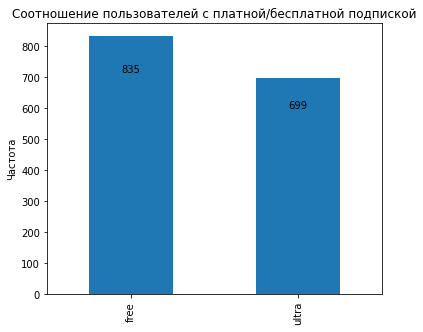

Доля пользователей без подписки составляет 0.54
Доля пользователей с подпиской составляет 0.46


In [15]:
users['subscription_type'].value_counts().plot.bar(figsize=(6, 5))
plt.title('Соотношение пользователей с платной/бесплатной подпиской')
plt.ylabel('Частота')
ax = plt.gca()
autolabel(ax.patches, height_factor=0.85)
plt.show()

print('Доля пользователей без подписки составляет', round(users[users['subscription_type'] == 'free']['name'].count() / users['subscription_type'].count(), 2))
print('Доля пользователей с подпиской составляет', round(users[users['subscription_type'] == 'ultra']['name'].count() / users['subscription_type'].count(), 2))

На графике видно, что в датасете чаще всего встречаются пользователи с бесплатной подпиской. То есть люди чаще всего пользуются разовыми поездками, нежели покупают абонементы для бесплатного старта поездки. Очевидно, что такие пользователи могут думать, что не так часто ездят для покупки подписки и дешевле будет просто каждый раз оплачивать старт, нежели брать подписку. При этом если сравнивать доли пользователей с подпиской и без, то можно сделать вывод о том, что их примерно одинаковое количество.

##### Возраст пользователей

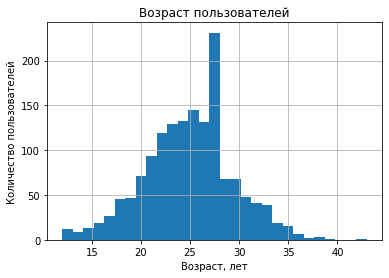

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [16]:
plt.hist(users['age'], bins=len(users['age'].unique()))
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

users['age'].describe()

Как оказалось, чаще всего в данных встречаются пользователи в возрасте 25 лет. Самые молодые пользователи, которые представлены в датасете имеют возраст 12 лет. Самым старшим пользователям 43 года. Данные в столбце распределены нормально и собираются вокруг значения 25.

#####  Расстояние, которое пользователь преодолел за одну поездку;

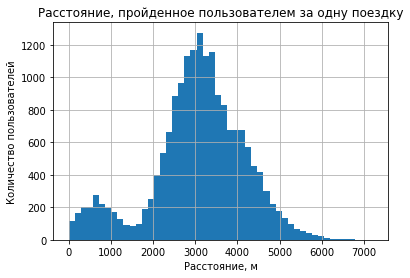

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [17]:
plt.hist(rides['distance'], bins=50)
plt.grid(True)
plt.title('Расстояние, пройденное пользователем за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество пользователей')
plt.show()

rides['distance'].describe()

Судя по гистограмме пользователи чаще всего проезжают чуть больше 3 км, медианное значение составляет 3133 м, а среднее 3070 - Различие между медианой и средним не такое уж и сильное, соответственно выбросы в данных практически отсутствуют. Присутствует два пика, смахивает на бимодальное распределение. Причем один пик приходится на приблизительно 600 м, а второй на медиану. Думаю эти пики обусловлены тем, что пользователи разделились на тех, кому нужно проехать короткую дистанцию (например от дома до магазина, от остановки до дома и т.д.), и тех, кто проезжает дистанцию подлиннее (например прогулка по улице на самокате, поездка от работы до дома и т.д.). Самая максимальная длина поездки составляет 7211 м, а самая короткая менее 1 м.

##### Продолжительность поездок

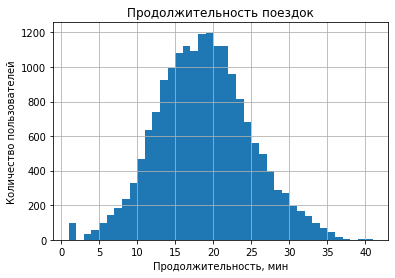

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [18]:
plt.hist(rides['duration'], bins=40)
plt.grid(True)
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность, мин')
plt.ylabel('Количество пользователей')
plt.show()

rides['duration'].describe()

Наши данные о длительности поездок распределены нормально. Среднее и медианное значения практически одинаковые и равняются 18.3 и 18 минутам соответствено. Именно столько времени обычно уходит у пользователей на поездки. Присутсвует небольшой пик в поездках до одной минуты. Возможно, это связано с тем, что пользователь передумал брать самокат в аренду выбрав другой способ передвижения. Или же пользователь случайно нажал на кнопку завершения поездки. Есть также возможность того, что техники проверяли работоспособность самокатов на месте, запуская их на короткое время. Вариантов может быть много, в любом случае тут не о чем переживать. Самая продолжительная поездка длилась около 41 минуты.

**Вывод**

В ходе исследовательского анализа данных были сделаны следующие выводы:
   - В данных чаще всего встречаются пользователи из регионов. На Первом месте находится Пятигорск, потом Екатеринбург. Москва занимает последнее место;
   - Доля пользователей без подписки составляет 54% от всех данных. Остальные 46% приходятся на подписчиков сервиса. Скорее всего большинство пользователей не так часто пользуется самокатами, поэтому им выгоднее заплатить за старт поездки, нежели брать себе подписку;
   - Чаще всего встречаются подьзователи возрастом 25 лет;
   - В чаще всего пользователь проезжает расстояние равное 3,1 км. Времени, как правило, на это уходит порядка 18 минут. Бывают поездки и подлинее и подольше. Например самая длинная составляет 7,2 км, а самая долгая целых 41 минуту!
   - Пользователи разделились на тех кто совершает короткие поездки и поездки на более длительные дистанции.

#### Шаг 4. Объединение данных

##### Объединение данных о пользователях в один датафрейм

In [19]:
data = rides.merge(users, on='user_id', how='left')
print(data.info())
data.sample(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB
None


,user_id,distance,duration,date,month,name,age,city,subscription_type
12714,1154,5101.223191,18.0,2021-09-20,9,Виолетта,27,Омск,free
7434,766,4354.875857,19.0,2021-09-12,9,Алёна,24,Краснодар,free
10159,968,2192.519644,20.0,2021-11-06,11,Павел,35,Краснодар,free
12007,1102,3478.859437,21.0,2021-03-28,3,Нелли,29,Тюмень,free
16799,1443,556.644088,10.0,2021-08-11,8,Виктория,23,Сочи,free


In [20]:
data = data.merge(subscriptions, how='left', on='subscription_type')
print(data.info())
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB
None


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
17810,1517,4227.123353,18.0,2021-01-21,1,Давид,25,Тюмень,free,8,50,0
12187,1115,2566.991879,24.0,2021-07-22,7,Анна,29,Екатеринбург,free,8,50,0
7077,739,4632.663259,28.0,2021-04-26,4,Ярослав,19,Пятигорск,free,8,50,0
12650,1150,3144.502689,16.0,2021-09-17,9,Рамиль,19,Омск,free,8,50,0
12410,1132,2147.383253,20.0,2021-07-12,7,Наталия,20,Москва,free,8,50,0


Мы объединили три датафрейма в один, теперь можно разбить наш большой датафрейм на более маленькие по признакам

##### Создание датафреймов с пользователями, в зависимости от наличия подписки

In [21]:
freesub = data[data['subscription_type'] == 'free']
freesub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [22]:
ultrasub = data[data['subscription_type'] == 'ultra']
ultrasub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


Готово! Ни одной строки не пропустили. Теперь у нас два датафрейма, которые различаются между собой наличием подписки у пользователей.

##### Визуализация данных о продолжительности и расстоянию поездок у пользователей с подпиской и без

Начнем наш аналис с пользователей, у которых подписка на сервис отсутствует.

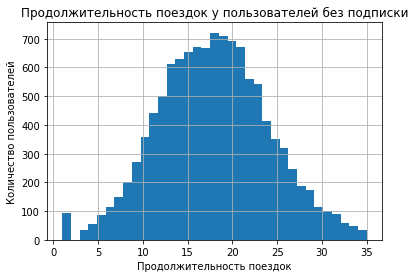

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [23]:
plt.hist(freesub['duration'], bins=35)
plt.title('Продолжительность поездок у пользователей без подписки')
plt.xlabel('Продолжительность поездок')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

freesub['duration'].describe()

Медианное и среднее значение продолжительности поездок у пользователей без подписки практически не различается и составляет 18 и 17.9 минут соответственно. При этом максимальная по продолжительности поездка длилась 35 минут. Заметны аномальные значения для промежутка до 1 минуты. Такая же ситуация наблюдалась в датафрейме до разделения на статусы пользователей, причины мы уже обсудили выше. Также есть вероятность, что такой пик образовался из-за того, что пользователь без подписки впервые решает попробовать для себя самокат и в первую минуту понимает, что не справится с управлением, что в итоге и приводет к немедленной остановке поездки. Распределение при этом нормальное. Давайте проверим какие пользователи берут самокат на время до 1 минуты.

In [24]:
freesub[freesub['duration'] <= 1].describe()

,user_id,distance,duration,month,age,minute_price,start_ride_price,subscription_fee
count,95.000000,95.000000,95.0,95.000000,95.000000,95.0,95.0,95.0
mean,1092.210526,5113.176549,1.0,6.484211,25.442105,8.0,50.0,0.0
std,244.028551,658.254104,0.0,3.709858,4.350876,0.0,0.0,0.0
min,701.000000,4030.308008,1.0,1.000000,13.000000,8.0,50.0,0.0
25%,901.000000,4611.510820,1.0,3.000000,22.500000,8.0,50.0,0.0
50%,1069.000000,5052.769411,1.0,6.000000,25.000000,8.0,50.0,0.0
75%,1310.500000,5488.459099,1.0,10.000000,29.000000,8.0,50.0,0.0
max,1524.000000,7211.007745,1.0,12.000000,36.000000,8.0,50.0,0.0


Мы имеем 95 строк с временем поездок до одной минуты. При этом средняя дистанция поездок составляет чуть больше 5 км. Довольно странно, ведь самокат, максимальная скорость которого составляет 21 км/ч даже при всем желании за полминуты 5 км не проедет. Стоит уточнить этот момент у тех кто выгружал данные. Возможно при подсчете продолжительности поездки произошел какой-то сбой и время поездки попросту не считалось. 95 строк от 11568 составляют 0.8%. Тем не менее удалять эти строки мы не будем. При подсчете выручки используем логическую индексацию, чтобы эти строки не исказили наши подсчеты и мы получили приближенные к реальному значения выручки.

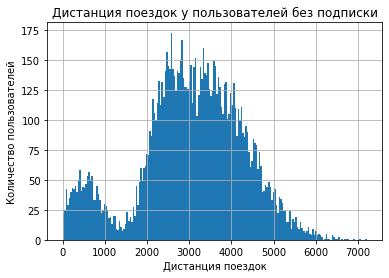

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [25]:
plt.hist(freesub['distance'], bins=200)
plt.title('Дистанция поездок у пользователей без подписки')
plt.xlabel('Дистанция поездок')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

freesub['distance'].describe()

Медианное и среднее значения дистанции поездок пользователей без подписки имеют небольшое различие. Медиана составляет 3114 м, а среднее 3045. Возьмем как показатель центральной тенденции медиану, т.к. она устойчивее к выбросам. Пользователи с бесплатной подпиской по преждему делятся на тех, кто совершает поездки на короткие дистанции и тех, кто выбирает дистанции подлинее. При этом заметно, что на проммежутке от 2500-3500 заметен небольшой провал в гистограмме. Напрашивается вывод, что пользователи совершающие поездки на длинные дистанции делятся еще на две группы. Короткие поездки, как правило, находятся в диапазоне до 1500 м, а более продолжительные по дистанции начинаются от 2000 м. Максимальная дистанция, которую проходили пользователи с бесплатной подпиской составляет 7211 м.

Начнем проверку датафрейма с пользователями, которые пользуются подпиской.

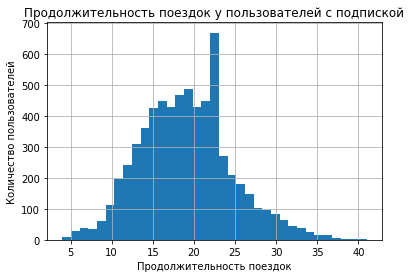

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

In [26]:
plt.hist(ultrasub['duration'], bins=35)
plt.title('Продолжительность поездок у пользователей c подпиской')
plt.xlabel('Продолжительность поездок')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

ultrasub['duration'].describe()

На гистограмме отсутствует пик на проммежутке до 1 минуты. Очевидно, что история с короткими поездками свойственна только для пользователей, которые не имеют в своем арсенале подписку. Возможно, что пользователи с подпиской при аренде самоката не размышляют о том, стоит ли тратить деньги на поездку или нет, т.к. старт у них бесплатный. Тут могут быть и другие причины. Распределение среди пользователей с подпиской стремится к нормальному и собирается вокруг медианного значения 19 минут. Максимальная поездка составляет 41 минуту. а вот минимальная уже 4 минуты. Очевидно, что это поездки по типу "доехать до магазина" или же "даехать от остановки до дома".

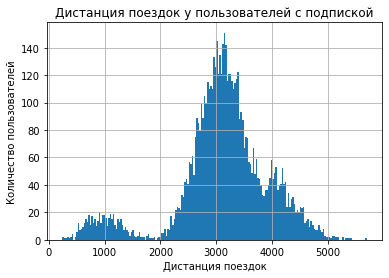

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [27]:
plt.hist(ultrasub['distance'], bins=200)
plt.title('Дистанция поездок у пользователей с подпиской')
plt.xlabel('Дистанция поездок')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()

ultrasub['distance'].describe()

На гистограмме дистанции поездок мы также наблюдаем две категории поездок: дальние и короткие. При этом короткими по расстоянию поездками  мы будем считать поездки до 2000 м. Начиная от 2500 и далее - поездки на дальние дистанции. Также стоит отметить что порог поездок на дальние и короткие дистанции у пользователей с подпиской выше на 500 м. Среднее и медиана практически равны и составляют 3115 и 3148 соответственно. Самая длинная дистанция составляет 5699 м, а самая короткая 244 м.

**Вывод**

В ходе исследования продолжительности поездок и их дистанции для разных пользователей, в зависимости от наличия подписки были выявлены следующие закономерности:
 - Средняя продолжительность поездки у пользователей без подписки составляет 18 минут. Пользователи с подпиской в среднем тратят 19 минут на поездку;
 - Средняя дистанция поездки у пользователей без подписки составляет 3114 м. Пользователи с подпиской в среднем проезжают около 3148 м.;
 - Сильных различий между продолжительностью поездок и дистанцией у пользователей с подпиской и без не наблюдается;
 - У обеих групп наблюдается кластеризация на две группы: поездки на короткую и длинную дистанции. При этом в зависимости от наличия подписки проммежутки для двух типов дистанции различаются. Так, например:
     * Для пользователей без подписки короткой дистанцией будет считаться поездка до 1500 м, а длинной дистанцией - поездка от 2000 м.
     * Для пользователей с подпиской короткой дистанцией будет считаться поездка до 2000 м, а длинной дистанцией - поездка от 2500 м.
 - У пользователей без подписки наблюдается пик на значениях до 1 минуты. При этом дистанции таких поездок составляют чуть больше 5 км. Причины этого пика лучше уточнять у тех, кто выгружал данные.

#### Шаг 5. Подсчёт выручки

##### Датафрейм с агрегированными данными по каждому пользователю

In [28]:
grouped_data = data.groupby(['user_id', 'month']
                           ).agg({'distance':'sum', 'duration':['sum', 'count'],
                                  'subscription_type':'first',
                                  'minute_price':'first',
                                  'start_ride_price':'first',
                                  'subscription_fee':'first'})

grouped_data.columns = ['distance', 'duration', 'count',
                         'subscription_type', 'minute_price',
                         'start_ride_price', 'subscription_fee']
grouped_data.reset_index(inplace=True)
display(grouped_data.head())


,user_id,month,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199


Мы создали датафрейм с агрегированной информацией по поездкам у каждого пользователя, в зависимости от месяца. Теперь приступим к подсчетам выручки, которую принес каждый пользователь в зависимости от месяца. 

Код ревьюера
df_agg_rev = data.groupby(['user_id', 'month']).agg({'distance':'sum', 'duration':['sum', 'count']})
display(df_agg_rev.head(3))

df_agg_rev.columns = {'distance', 'duration', 'count'} # Здесь ошибка в переименовании столбцов
display(df_agg_rev.head(3))


Код ревьюера

df_aggregated = data.groupby(['user_id', 'month']
                           ).agg({'distance':'sum', 'duration':['sum', 'count'],
                                  'subscription_type':'first',
                                  'minute_price':'first',
                                  'start_ride_price':'first',
                                  'subscription_fee':'first'})

Переименование столбцов
df_aggregated.columns = ['sum_distance', 'sum_duration', 'count',
                         'subscription_type', 'minute_price',
                         'start_ride_price', 'subscription_fee']
Сброс индекса
df_aggregated.reset_index(inplace=True)

display(df_aggregated.head())
print(df_aggregated.shape[0])

##### Подсчет выручки

In [29]:
grouped_data['income'] = (
    grouped_data['start_ride_price'] * grouped_data['count'] 
    + grouped_data['minute_price'] * grouped_data['duration'] 
    + grouped_data['subscription_fee']
)

grouped_data.head(10)

,user_id,month,distance,duration,count,subscription_type,minute_price,start_ride_price,subscription_fee,income
0,1,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,4,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,8,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,10,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,11,7003.499363,56.0,3,ultra,6,0,199,535.0
5,1,12,6751.629942,28.0,2,ultra,6,0,199,367.0
6,2,3,10187.723006,63.0,3,ultra,6,0,199,577.0
7,2,4,6164.381824,40.0,2,ultra,6,0,199,439.0
8,2,6,3255.338202,14.0,1,ultra,6,0,199,283.0
9,2,7,6780.722964,48.0,2,ultra,6,0,199,487.0


Вот мы и посчитали выручку, которую принес каждый пользователь помесячно.

#### Шаг 6. Проверка гипотез

Теперь приступим к проверке гипотез, используя статистические методы.

#####  Тратят ли пользователи с подпиской больше времени на поездки?

Чтобы оценить высказывание о том, что пользователи с подпиской тратят больше времени на поездки сформируем **Нулевую** гипотезу и  **Альтернативную** гипотезу:
 - **H0**: Среднее время, которое тратят на поездки пользователи с подпиской равно среднему времене, которое тратят на поездки пользователи без подписки;
 - **H1**: Среднее время, которое тратят пользователи с подпиской на поездки больше, чем у пользователей без подписки.
 
 Уровень статистической значимости `alpha` будем считать равным 5%
 
 Мы имеем дело с двумя независимыми выборками из двух независимых генеральных совокупностей, поэтому использовать будем `ttest_ind` из библиотеки `scipy.stats`
 
 Т.к. в альтернативной гипотезе мы допускаем факт, что пользователи с подпиской тратят **больше** времени, то используем односторонний тест, где в аргументе `alternative` укажем параметр `greater`

In [30]:
alpha = 0.05
timecomp = st.ttest_ind(ultrasub['duration'], freesub['duration'], alternative='greater')
print(f'P-value равно: {timecomp.pvalue}')


if timecomp.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, т.к. есть основания предполагать, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

P-value равно: 2.4959453720736625e-34
Отвергаем нулевую гипотезу, т.к. есть основания предполагать, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки


p-value в нашем исследовании имеет экстремально низкое значение, гораздо меньше, чем заданный уровень стат. значимости. Следовательно есть основания предполагать, что пользователи с подпиской действительно тратят на поездки больше времени, а это значит, что такие пользователи  "выгоднее" для компании.

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное с точки зрения износа для самоката расстояние 3130 м.

Начнем с формулировки гипотез:
 - **H0**: Расстояние, которое проезжает пользователь с подпиской за одну поездку равно 3130 м.
 - **H1**: Расстояние, которое проезжает пользователь с подпиской за одну поездку больше 3130 м. 
  
Уровень статистической значимости `alpha` будем считать равным 5%
Мы имеем дело с анализом одной выборки, где альтернативная гипотеза принимает значения по правую сторону от заданной величины. Используем метод `ttest_1samp`, в аргументе `alternative` укажем параметр `greater` 

In [31]:
value = 3130
distultra = st.ttest_1samp(ultrasub['distance'], value, alternative='greater')

print(f'P-value равно: {distultra.pvalue}')


if distultra.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, т.к. есть основания предполагать, что пользователи с подпиской в среднем проезжают меньшее расстояние, по сравнению с оптимальным с точки зрения износа для самоката')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

P-value равно: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


p-value равно 92%, следовательно у нас нет оснований отвергнуть нулевую гипотезу о равенстве среднего расстояния, которое проезжает пользователь с подпиской за одну поездку, 3130 м. При этом мы также не отклоняем гипотезу о том, что пользователи проезжают расстояние меньше заявленного, т.к. в разрезе нашего исследования рассматривалась правосторонняя гипотеза. Можно сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальное с точки зрения износа самоката

##### Сравнение помесячной выручки пользователей с подпиской и без.

Гипотезы будут звучать так:
 - **H0**: Помесячные выручки пользователей с подпиской и без равны.
 - **H1**: Помесячная выручка у пользователей с подпиской выше.
 
 Уровень стат. значимости устанавливаем 5%
 Мы имеем дело с двумя независимыми выборками, где в качестве альтернативной гипотезы будет взята правосторонняя. Используем метод `ttest_ind`.

In [32]:
monthly_income = st.ttest_ind(
    grouped_data[grouped_data['subscription_type'] == 'ultra']['income'],
    grouped_data[grouped_data['subscription_type'] == 'free']['income'],
    alternative='greater'
)
print(f'P-value равно: {monthly_income.pvalue}')


if monthly_income.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, т.к. есть основания предполагать, что пользователи с подпиской приносят больше выручки помесячно, нежели пользователи без подписки')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

P-value равно: 1.8850394384715216e-31
Отвергаем нулевую гипотезу, т.к. есть основания предполагать, что пользователи с подпиской приносят больше выручки помесячно, нежели пользователи без подписки


Тест показал нам, что есть основания отвергнуть нулевую гипотезу о равенстве помесячной выручки пользователей с подписками и без в пользу альтернативной. Пользователи с подпиской приносят больше выручки помесячно, нежели пользователи без подписки.

##### Количество обращений в техподдержку до и после обновления сервера. 

В данном случае мы имеем дело с двумя зависимыми выборками, т.к. мы проверяем среднии одной генеральной совокупности (пользователей сервиса) до и после обновления. Типичный пример для t-теста для зависимых (парных) выборок. Используем метот из библиотеки `scipy.stats.ttest_rel()`, где в качестве аргументов будут использованы выборки до и после изменений. Т.к. в качестве альтернативной гипотезы мы будем проверять высказывание о снижении количества обращений (среднее выборки после изменений меньше среднего выборки до изменений), в качестве аргумента `alternative` мы используем параметр `less` (площадь фигуры под левым хвостом). При передаче параметров в аргументы метода на первом месте будет стоять выборка до изменений, а на втором - выборка после изменений, т.к. порядок важен.

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Для выполнения этой задачи идеально подойдет биномиальное распределение, т.к. каждая отправка промокода по факту является экспериментом Бернулии с двумя исходами, где:
 - **p = 10%** - клиент продлил подписку;
 - **1 - p** - клиент не продлил подписку;
 
Для определения количество промокодов мы должны найти такое количество **n**(число отправленных промокодом), при котором вероятность не выполнить план будет составлять **5%**.
В качестве параметра **k** мы берем минимальное количество клиентов, которые должны продлить подписку  - 100.
Уровень стат значимости мы ставим **5%**. 
___
Формула вероятности выполнения плана будет выглядеть так: **P(X>=k) = 1 - P(X<k)**
___
Мы будем искать такое **n**, при котором **P(X<k) > alpha**

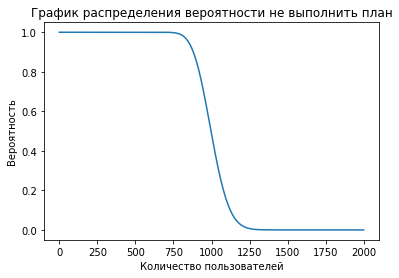

Минимальное количество промокодов, которые нужно разослать составляет 1161


In [33]:
p = 0.1
k = 99
alpha = 0.05

distr = []

for n in range(0, 2000):
    distr.append(st.binom.cdf(k, n, p))

    
plt.plot(distr)
plt.title('График распределения вероятности не выполнить план')
plt.xlabel('Количество пользователей')
plt.ylabel('Вероятность')
plt.show()

print('Минимальное количество промокодов, которые нужно разослать составляет', pd.Series(distr)[pd.Series(distr) <= alpha].index.min())

##### 7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Для решения этой задачи будем использовать биномиальное распределение, а именно аппроксимацию биномиального распределения нормальным. У нас есть общее количество уведомлений **n = 1 млн**. Нам нужно узнать вероятность того, что уведомление откроют не более **k = 399500** пользователей, при условии, что вероятность открытия уведомления составляет **p = 0.4**.
Для того, чтобы аппроксимировать биномиальное распределение нормальным вопрользуемся следующими свойствами:
 - **mu = n * p** - математическое ожидание биномиального распределения;
 - **sigma **2 = n * p * (1 - p)** - дисперсия биномиального распределения.

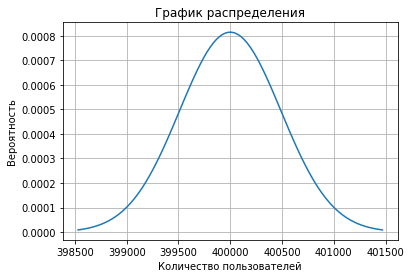

Вероятность того, что уведомление откроет не более 399,5 тыс. пользователей составляет 15.37 %


In [34]:
n = 1000000
p = 0.4
k = 399500

mu = n*p
sigma = np.sqrt(n * p * (1 - p)) 

distr = st.norm(mu, sigma)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y = distr.pdf(x) #генерация значений плотности вероятности для каждого значения x

plt.plot(x, y)
plt.xlabel('Количество пользователей')
plt.ylabel('Вероятность')
plt.title('График распределения')
plt.grid(True)
plt.show()

print(f'Вероятность того, что уведомление откроет не более 399,5 тыс. пользователей составляет {round(distr.cdf(k) * 100, 2)} %')

#### Вывод

В ходе данного исследования мы анализировали информацию о пользователях сервиса по аренде самокатов GoFast. Перед нами стояла задача провести статистические исследования и проверить несколько гипотез:
  1. Тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки;
  2. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное с точки зрения износа для самоката расстояние 3130 м;
  3. Помесячная выручка пользователей с подпиской выше, чем у пользователей без подписки.


Прежде чем приступить к статистическому анализу данных, мы занялись предобработкой данных, в ходе которой были выполнены следующие действия:
 - Изменили тип данных в столбце `date` датафрейма с информацией о поездках с `object` на  `datetime`;
 - Добавили в датафрейм отдельный столбец с месяцем поездок для дальнейшего исследования;
 - Округлили значения в столбце с продолжительностью поездок;
 - Удалили 31 строку дубликат (1.98% данных). Дубликаты находились на последних строках датафрейма. Очевидно их добавили случайно или же произошла какая-то техническая ошибка.

После того, как мы провели т.н. preprocessing, мы приступили к исследовательскому анализу данных в ходе которого были выявлены следующие закономерности:
 1. **Частота встречаемости городов**
 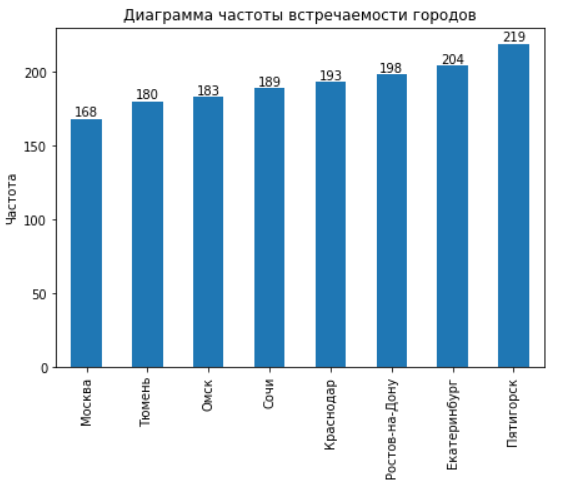
 Судя по диаграмме в нашем датафрейме чаще всего встречаются пользователи из Пятигорска. На втором месте по числу пользователей находится Екатеринбург. Последнее место по числу пользователей отдается Москве. Видимо сервис по аренде самокатов чаще всего предоставляет свои услуги в регионах.
 2. **Соотношение пользователей с подпиской и без**
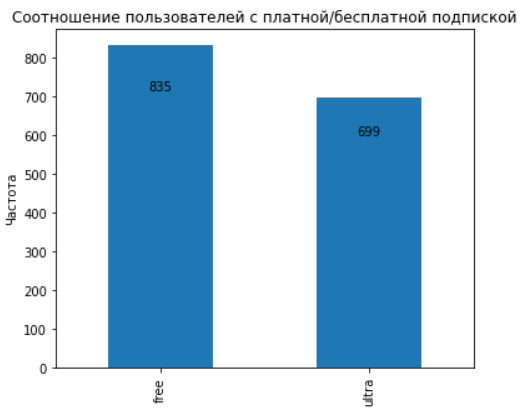
Доля пользователей без подписки составляет 54%. Пользователи с подпиской, соответственно, составляют 46%. На графике видно, что в датасете чаще всего встречаются пользователи с бесплатной подпиской. То есть люди чаще всего пользуются разовыми поездками, нежели покупают абонементы для бесплатного старта поездки. Очевидно, что такие пользователи могут думать, что не так часто ездят для покупки подписки и дешевле будет просто каждый раз оплачивать старт, нежели брать подписку. При этом если сравнивать доли пользователей с подпиской и без, то можно сделать вывод о том, что их примерно одинаковое количество.
 3. **Возраст пользователей**
 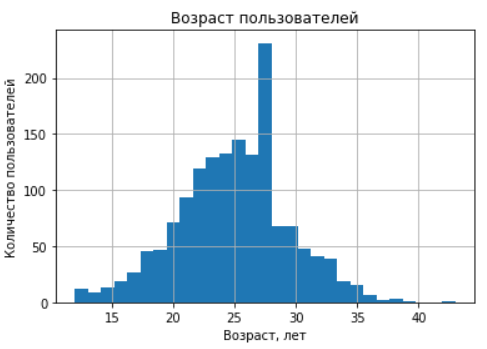
Как оказалось, чаще всего в данных встречаются пользователи в возрасте 25 лет. Самые молодые пользователи, которые представлены в датасете имеют возраст 12 лет. Самым старшим пользователям 43 года. Данные в столбце распределены нормально и собираются вокруг значения 25.
 4. **Расстояние, которое пользователи преодолевают за одну поездку**
 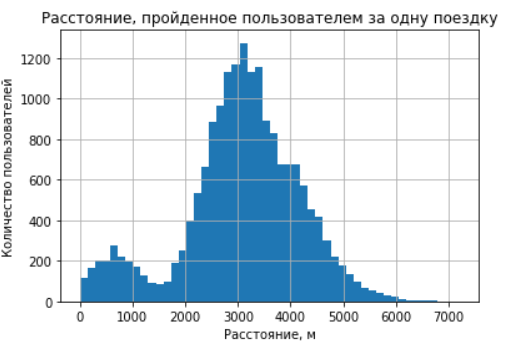
Судя по гистограмме пользователи чаще всего проезжают чуть больше 3 км, медианное значение составляет 3133 м, а среднее 3070 - Различие между медианой и средним не такое уж и сильное, соответственно выбросы в данных практически отсутствуют. Присутствует два пика, смахивает на бимодальное распределение. Причем один пик приходится на приблизительно 600 м, а второй на медиану. Думаю эти пики обусловлены тем, что пользователи разделились на тех, кому нужно проехать короткую дистанцию (например от дома до магазина, от остановки до дома и т.д.), и тех, кто проезжает дистанцию подлиннее (например прогулка по улице на самокате, поездка от работы до дома и т.д.). Самая максимальная длина поездки составляет 7211 м, а самая короткая менее 1 м.
 5. **Продолжительность поездок**
 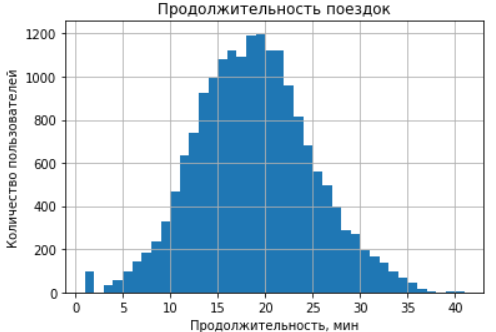
Наши данные о длительности поездок распределены нормально. Среднее и медианное значения практически одинаковые и равняются 18.3 и 18 минутам соответствено. Именно столько времени обычно уходит у пользователей на поездки. Присутсвует небольшой пик в поездках до одной минуты. Возможно, это связано с тем, что пользователь передумал брать самокат в аренду выбрав другой способ передвижения. Или же пользователь случайно нажал на кнопку завершения поездки. Есть также возможность того, что техники проверяли работоспособность самокатов на месте, запуская их на короткое время. Вариантов может быть много, в любом случае тут не о чем переживать. Самая продолжительная поездка длилась около 41 минуты.

**Вывод**

В ходе исследовательского анализа данных были сделаны следующие выводы:
   - В данных чаще всего встречаются пользователи из регионов. На Первом месте находится Пятигорск, потом Екатеринбург. Москва занимает последнее место;
   - Доля пользователей без подписки составляет 54% от всех данных. Остальные 46% приходятся на подписчиков сервиса. Скорее всего большинство пользователей не так часто пользуется самокатами, поэтому им выгоднее заплатить за старт поездки, нежели брать себе подписку;
   - Чаще всего встречаются подьзователи возрастом 25 лет;
   - В чаще всего пользователь проезжает расстояние равное 3,1 км. Времени, как правило, на это уходит порядка 18 минут. Бывают поездки и подлинее и подольше. Например самая длинная составляет 7,2 км, а самая долгая целых 41 минуту!
   - Пользователи разделились на тех кто совершает короткие поездки и поездки на более длительные дистанции.

Далее мы объединили три датафрейма в один для того, чтобы потом создать два отдельных датафрейма в зависимости от наличия подписки у пользователей. После чего еще раз провели исследование времени и расстояния, которые пользователи тратят и преодолевают, в зависимости от наличия подписки. Вот что нам удалось выяснить:
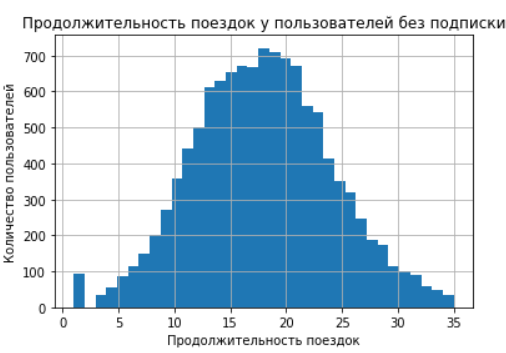
Медианное и среднее значение продолжительности поездок у пользователей без подписки практически не различается и составляет 18 и 17.9 минут соответственно. При этом максимальная по продолжительности поездка длилась 35 минут. Заметны аномальные значения для промежутка до 1 минуты. Такая же ситуация наблюдалась в датафрейме до разделения на статусы пользователей, причины мы уже обсудили выше. Также есть вероятность, что такой пик образовался из-за того, что пользователь без подписки впервые решает попробовать для себя самокат и в первую минуту понимает, что не справится с управлением, что в итоге и приводет к немедленной остановке поездки. Распределение при этом нормальное. Давайте проверим какие пользователи берут самокат на время до 1 минуты.
Далее мы посмотрели строки со значениями длительности одной поездки до 1 минуты и вот что нам удалось выяснить. Мы имеем 95 строк с временем поездок до одной минуты. При этом средняя дистанция поездок составляет чуть больше 5 км. Довольно странно, ведь самокат, максимальная скорость которого составляет 21 км/ч даже при всем желании за полминуты 5 км не проедет. Стоит уточнить этот момент у тех кто выгружал данные. Возможно при подсчете продолжительности поездки произошел какой-то сбой и время поездки попросту не считалось. 95 строк от 11568 составляют 0.8%. Тем не менее удалять эти строки мы не будем. При подсчете выручки используем логическую индексацию, чтобы эти строки не исказили наши подсчеты и мы получили приближенные к реальному значения выручки.
 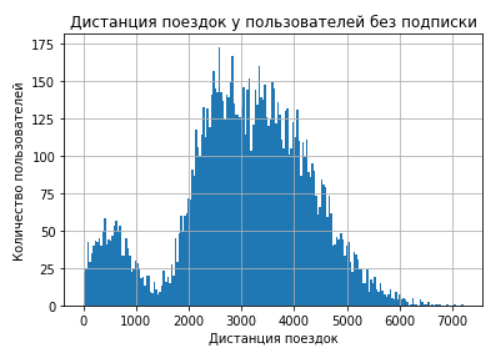
 Медианное и среднее значения дистанции поездок пользователей без подписки имеют небольшое различие. Медиана составляет 3114 м, а среднее 3045. Возьмем как показатель центральной тенденции медиану, т.к. она устойчивее к выбросам. Пользователи с бесплатной подпиской по преждему делятся на тех, кто совершает поездки на короткие дистанции и тех, кто выбирает дистанции подлинее. При этом заметно, что на проммежутке от 2500-3500 заметен небольшой провал в гистограмме. Напрашивается вывод, что пользователи совершающие поездки на длинные дистанции делятся еще на две группы. Короткие поездки, как правило, находятся в диапазоне до 1500 м, а более продолжительные по дистанции начинаются от 2000 м. Максимальная дистанция, которую проходили пользователи с бесплатной подпиской составляет 7211 м.
 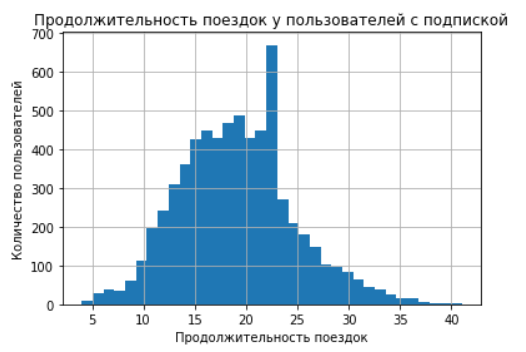
 На гистограмме отсутствует пик на проммежутке до 1 минуты. Очевидно, что история с короткими поездками свойственна только для пользователей, которые не имеют в своем арсенале подписку. Возможно, что пользователи с подпиской при аренде самоката не размышляют о том, стоит ли тратить деньги на поездку или нет, т.к. старт у них бесплатный. Тут могут быть и другие причины. Распределение среди пользователей с подпиской стремится к нормальному и собирается вокруг медианного значения 19 минут. Максимальная поездка составляет 41 минуту. а вот минимальная уже 4 минуты. Очевидно, что это поездки по типу "доехать до магазина" или же "даехать от остановки до дома".
 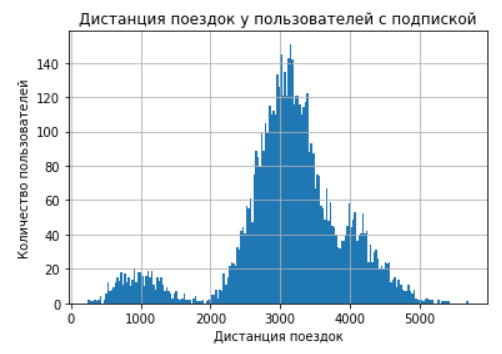
 На гистограмме дистанции поездок мы также наблюдаем две категории поездок: дальние и короткие. При этом короткими по расстоянию поездками  мы будем считать поездки до 2000 м. Начиная от 2500 и далее - поездки на дальние дистанции. Также стоит отметить что порог поездок на дальние и короткие дистанции у пользователей с подпиской выше на 500 м. Среднее и медиана практически равны и составляют 3115 и 3148 соответственно. Самая длинная дистанция составляет 5699 м, а самая короткая 244 м.

**Вывод**

В ходе исследования продолжительности поездок и их дистанции для разных пользователей, в зависимости от наличия подписки были выявлены следующие закономерности:
 - Средняя продолжительность поездки у пользователей без подписки составляет 18 минут. Пользователи с подпиской в среднем тратят 19 минут на поездку;
 - Средняя дистанция поездки у пользователей без подписки составляет 3114 м. Пользователи с подпиской в среднем проезжают около 3148 м.;
 - Сильных различий между продолжительностью поездок и дистанцией у пользователей с подпиской и без не наблюдается;
 - У обеих групп наблюдается кластеризация на две группы: поездки на короткую и длинную дистанции. При этом в зависимости от наличия подписки проммежутки для двух типов дистанции различаются. Так, например:
     * Для пользователей без подписки короткой дистанцией будет считаться поездка до 1500 м, а длинной дистанцией - поездка от 2000 м.
     * Для пользователей с подпиской короткой дистанцией будет считаться поездка до 2000 м, а длинной дистанцией - поездка от 2500 м.
 - У пользователей без подписки наблюдается пик на значениях до 1 минуты. При этом дистанции таких поездок составляют чуть больше 5 км. Причины этого пика лучше уточнять у тех, кто выгружал данные.

После объединения данный и разбивки на два датафрейма мы создали еще один датафрейм с агрегированными данными о поездках каждого пользователя, в зависимости от месяца поездок и подсчитали выручку, которую принес каждый пользователь помесясно. Если какой-то из месяцев отсутствует в датафрейме, то это значит, что у пользователя просто напросто не было поездок за этот месяц. 

После агрегирования данных мы приступили к проверке статистических гипотез.
 1. **Тратят ли пользователи с подпиской больше времени на поездки**.

Чтобы оценить высказывание о том, что пользователи с подпиской тратят больше времени на поездки сформируем **Нулевую** гипотезу и  **Альтернативную** гипотезу:
 - **H0**: Среднее время, которое тратят на поездки пользователи с подпиской равно среднему времене, которое тратят на поездки пользователи без подписки;
 - **H1**: Среднее время, которое тратят пользователи с подпиской на поездки больше, чем у пользователей без подписки.
В ходе исследования вероятность того, что мы получим такие же или более выраженные значения, при условии, что нулевая гипотеза верна оказалась настолько низка, что мы с уверенностью можем отвергать нулевую гипотезу в пользу альтернативной. 
 
 2. **Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимальное с точки зрения износа для самоката расстояние 3130 м** 
Начнем с формулировки гипотез:
 - **H0**: Расстояние, которое проезжает пользователь с подпиской за одну поездку равно 3130 м.
 - **H1**: Расстояние, которое проезжает пользователь с подпиской за одну поездку больше 3130 м. 
В ходе исследования вероятность того, что мы получим такие же или более выраженные значения, при условии, что нулевая гипотеза верна оказалась равна 92%. У нас нет оснований отвергать нулевую гипотезу. При этом мы также не отклоняем гипотезу о том, что пользователи проезжают расстояние меньше заявленного, т.к. в разрезе нашего исследования рассматривалась правосторонняя гипотеза. Можно сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальное с точки зрения износа самоката
 
 3. **Сравнение помесячной выручки пользователей**
Гипотезы будут звучать так:
 - **H0**: Помесячные выручки пользователей с подпиской и без равны.
 - **H1**: Помесячная выручка у пользователей с подпиской выше.

Тест показал нам, что есть основания отвергнуть нулевую гипотезу о равенстве помесячной выручки пользователей с подписками и без в пользу альтернативной. Пользователи с подпиской приносят больше выручки помесячно, нежели пользователи без подписки.
 4. **Количество обращений в техподдержку**
Перед нами стоит задача выяснить какой тест применять для исследования уровня обращений в техподдержку до и после обновления серверов. В данном случае мы имеем дело с двумя зависимыми выборками, т.к. мы проверяем среднии одной генеральной совокупности (пользователей сервиса) до и после обновления. Типичный пример для t-теста для зависимых (парных) выборок. Используем метот из библиотеки `scipy.stats.ttest_rel()`, где в качестве аргументов будут использованы выборки до и после изменений. Т.к. в качестве альтернативной гипотезы мы будем проверять высказывание о снижении количества обращений (среднее выборки после изменений меньше среднего выборки до изменений), в качестве аргумента `alternative` мы используем параметр `less` (площадь фигуры под левым хвостом). При передаче параметров в аргументы метода на первом месте будет стоять выборка до изменений, а на втором - выборка после изменений, т.к. порядок важен. 

После проверки гипотез мы приступили к решению задач и построению распределений.
В первой задаче нам необходимо выяснить количество отправленных промокодов, необходимое для того, чтобы как минимум 100 пользователей продлили подпискую. Эту задачу мы решили с помощью биномиального распределения, т.к. у каждой отправки промокода есть два исхода:
 - клиент продлил подписку;
 - клиент не продлил подписку;
Мы получили следующий график распределения:
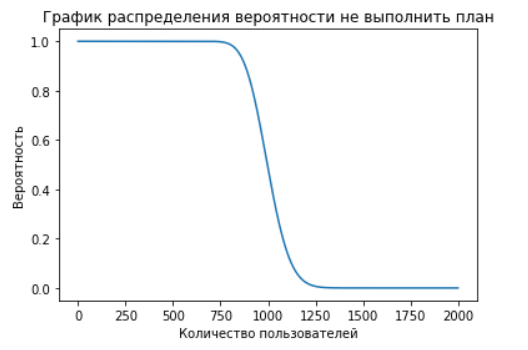
Исходя из этого распределения нам нужно отправить **1161 промокод**, чтобы с вероятностью в 10% продлились минимум 100 пользователей.
___
В следующей задаче нам необходимо было выявить вероятность того, что из 1 млн пользовалетей 399,5 тыс. откроют письмо. Тут мы аппроксимировали биномиальное распределение нормальным. и получили следующий график распределения:
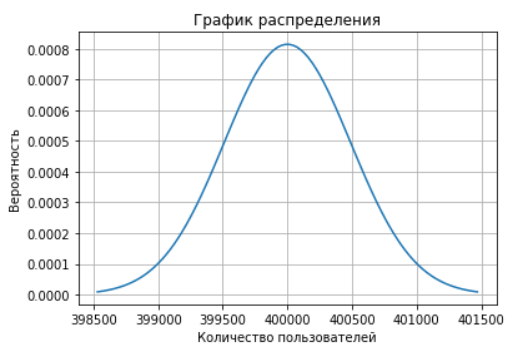
Как оказалось, вероятность того, что письмо откроет 399,5 тыс. пользователей составила **15,37**%

Мы провели большое исследование, проверили несколько гипотез, которые в дальнейшем помогут бизнесу принять решение по развитию.